In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow import keras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import numpy as np

import tensorflow as tf
from scipy.linalg import sqrtm
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input


import os
from tensorflow.keras import layers
from keras.datasets.cifar10 import load_data
import matplotlib.pyplot as plt
import time
from IPython import display

from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate

from matplotlib import pyplot as plt

# Initialize rng
rng = np.random.default_rng(2022)

In [9]:
batch_size = 32 # This is a tunable hyperparameter
input_shape = (128, 128) # note we are reducing the size of the image
data_dir = r'/content/drive/MyDrive/split_archive'
train_ds = tf.keras.utils.image_dataset_from_directory(os.path.join(data_dir, 'train'),
                                                       seed=rng.integers(500000),
                                                       image_size=input_shape,
                                                       color_mode='grayscale',
                                                       batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(os.path.join(data_dir, 'val'),
                                                     seed=rng.integers(500000),
                                                     image_size=input_shape,
                                                     color_mode='grayscale',
                                                     batch_size=batch_size)
test_ds = tf.keras.utils.image_dataset_from_directory(os.path.join(data_dir, 'test'),
                                                      seed=rng.integers(500000),
                                                      image_size=input_shape,
                                                      color_mode='grayscale',
                                                      batch_size=batch_size)

Found 3954 files belonging to 2 classes.
Found 841 files belonging to 2 classes.
Found 844 files belonging to 2 classes.


In [10]:
# Noise layer to add Gaussian noise
# This layer adds zero-mean Gussian noise with the given standard deviation
noise_layer = GaussianNoise(0.2)

# API to change data from X, y to X_noisy, X_clean (disregard class variable)
def change_inputs_outputs(images, labels):

  # Reshape images to shape=128x128; these are clean images, i.e., output
  X_clean = tf.image.resize(images, list(input_shape))
  # Add noise to create synthetic input imaages
  X_noisy = noise_layer(X_clean)
  # The function must return data in the format - input, output
  return X_noisy, X_clean

In [11]:
# Map train, validation, and output sets to the desired input, output configuration using the API we created
train_ds = train_ds.map(change_inputs_outputs)
val_ds = val_ds.map(change_inputs_outputs)
test_ds = test_ds.map(change_inputs_outputs)

#### Fully connected layers Denoising with L2 norm

In [12]:
latent_dim = 32

input_shape = (128, 128, 1)

# Encoder
encoder_input = layers.Input(shape=input_shape)
flatten_input = layers.Flatten()(encoder_input)
encoded = layers.Dense(256, activation='relu', activity_regularizer=regularizers.l2(0.01))(flatten_input)
encoded = layers.Dense(128, activation='relu', activity_regularizer=regularizers.l2(0.01))(encoded)
encoded = layers.Dense(latent_dim, activation='relu', activity_regularizer=regularizers.l2(0.01))(encoded)
# Decoder
decoded = layers.Dense(256, activation='relu', activity_regularizer=regularizers.l2(0.01))(encoded)
decoded = layers.Dense(128 * 128, activation='sigmoid')(decoded)
decoded = layers.Reshape(input_shape)(decoded)

# Autoencoder model
autoencoder = Model(encoder_input, decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 256)               4194560   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 256)               8448      
                                                                 
 dense_4 (Dense)             (None, 16384)             421068

In [14]:
# Early stopping
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=0,
                   patience=10,
                   restore_best_weights=True)

# Train
history = autoencoder.fit(train_ds,
                          epochs=30,
                          batch_size=256,
                          shuffle=True,
                          callbacks=[es],
                          validation_data= test_ds)

Epoch 1/30
124/124 [==============================] - 319s 3s/step - loss: 36047.1367 - val_loss: 20132.0566
Epoch 2/30
124/124 [==============================] - 13s 99ms/step - loss: 19944.0117 - val_loss: 20101.0859
Epoch 3/30
124/124 [==============================] - 13s 99ms/step - loss: 19939.3828 - val_loss: 20100.7988
Epoch 4/30
124/124 [==============================] - 14s 104ms/step - loss: 19939.2520 - val_loss: 20100.7344
Epoch 5/30
124/124 [==============================] - 13s 101ms/step - loss: 19939.2031 - val_loss: 20100.6973
Epoch 6/30
124/124 [==============================] - 13s 102ms/step - loss: 19939.1758 - val_loss: 20100.6621
Epoch 7/30
124/124 [==============================] - 13s 103ms/step - loss: 19939.1348 - val_loss: 20100.6250
Epoch 8/30
124/124 [==============================] - 13s 98ms/step - loss: 19939.1035 - val_loss: 20100.5918
Epoch 9/30
124/124 [==============================] - 14s 106ms/step - loss: 19939.0723 - val_loss: 20100.5586
Epoch 

In [15]:
# plot learning curves
def summarize_diagnostics(history):
    fig, ax = plt.subplots(1, figsize=(8, 8))
    # plot loss
    ax.set_title('Loss Curves', fontsize=20)
    ax.plot(history.history['loss'], label='train')
    ax.plot(history.history['val_loss'], label='test')
    ax.set_xlabel('Epochs', fontsize=15)
    ax.set_ylabel('Loss', fontsize=15)
    ax.legend(fontsize=15)

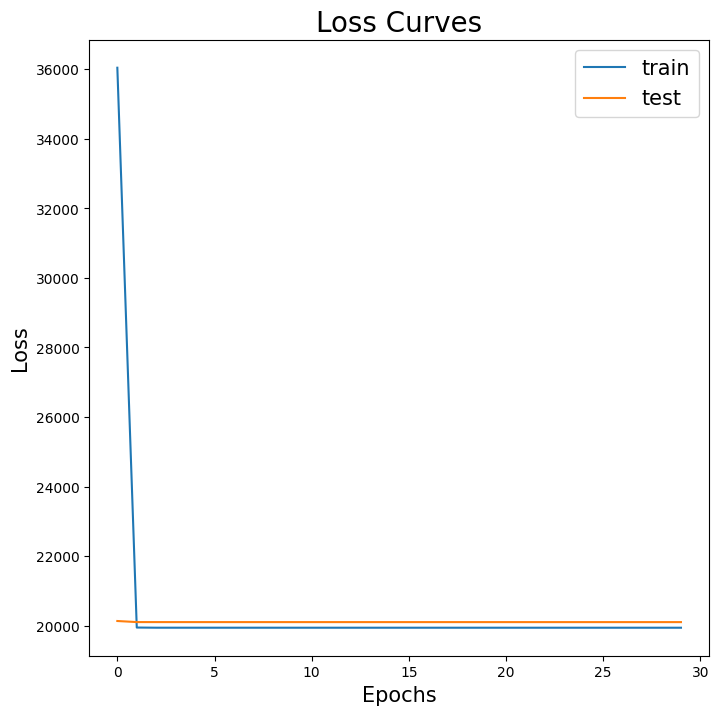

In [16]:
# loss curves
summarize_diagnostics(history)

In [17]:
decoded_imgs = autoencoder.predict(test_ds)

27/27 [==============================] - 3s 65ms/step


In [18]:
# unpack noisy_images and clean_images from tensors pair
noisy_images = []
clean_images = []

for noisy_image, clean_image in test_ds:
   noisy_images.extend(noisy_image.numpy())
   clean_images.extend(clean_image.numpy())

noisy_images_np = np.array(noisy_images)
clean_images_np = np.array(clean_images)

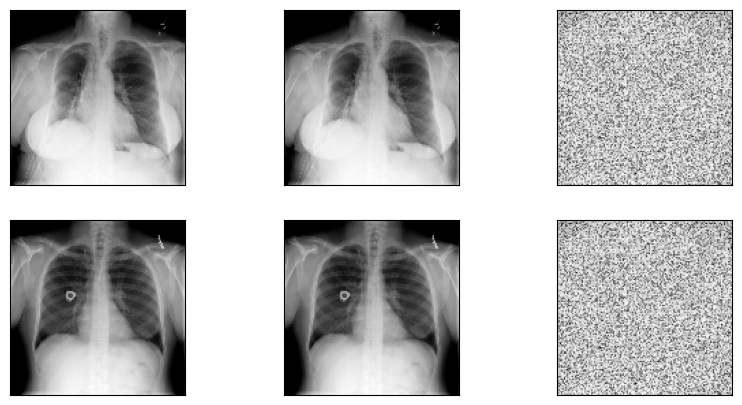

In [19]:
n = 2  # Number of images to display
plt.figure(figsize=(10, 5))
for i in range(n):

    # Display clean_images_np
    ax = plt.subplot(2, 3,  1+(i*3) )
    plt.imshow(clean_images_np[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy_images_np
    ax = plt.subplot(2, 3, 2+(i*3) )
    plt.imshow(noisy_images_np[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy_images_np
    ax = plt.subplot(2, 3, 3+(i*3))
    plt.imshow(decoded_imgs[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# fully connected layer with Huber loss

In [20]:
latent_dim = 32

input_shape = (128, 128, 1)

# Encoder
encoder_input = layers.Input(shape=input_shape)
flatten_input = layers.Flatten()(encoder_input)
encoded = layers.Dense(256, activation='relu', activity_regularizer=regularizers.l2(0.01))(flatten_input)
encoded = layers.Dense(128, activation='relu', activity_regularizer=regularizers.l2(0.01))(encoded)
encoded = layers.Dense(latent_dim, activation='relu', activity_regularizer=regularizers.l2(0.01))(encoded)
# Decoder
decoded = layers.Dense(256, activation='relu', activity_regularizer=regularizers.l2(0.01))(encoded)
decoded = layers.Dense(128 * 128, activation='sigmoid')(decoded)
decoded = layers.Reshape(input_shape)(decoded)

# Autoencoder model
autoencoder = Model(encoder_input, decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='huber_loss')

# Display the model summary
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 flatten_1 (Flatten)         (None, 16384)             0         
                                                                 
 dense_5 (Dense)             (None, 256)               4194560   
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 32)                4128      
                                                                 
 dense_8 (Dense)             (None, 256)               8448      
                                                                 
 dense_9 (Dense)             (None, 16384)             4210

In [21]:
# Early stopping
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=0,
                   patience=10,
                   restore_best_weights=True)

# Train
history = autoencoder.fit(train_ds,
                          epochs=30,
                          batch_size=256,
                          shuffle=True,
                          callbacks=[es],
                          validation_data= test_ds)

Epoch 1/30
124/124 [==============================] - 15s 98ms/step - loss: 18296.2363 - val_loss: 126.7253
Epoch 2/30
124/124 [==============================] - 13s 102ms/step - loss: 125.9492 - val_loss: 126.5796
Epoch 3/30
124/124 [==============================] - 13s 103ms/step - loss: 125.7977 - val_loss: 126.4467
Epoch 4/30
124/124 [==============================] - 13s 100ms/step - loss: 125.7048 - val_loss: 126.3901
Epoch 5/30
124/124 [==============================] - 13s 98ms/step - loss: 125.6692 - val_loss: 126.3691
Epoch 6/30
124/124 [==============================] - 13s 101ms/step - loss: 125.6551 - val_loss: 126.3597
Epoch 7/30
124/124 [==============================] - 13s 103ms/step - loss: 125.6479 - val_loss: 126.3542
Epoch 8/30
124/124 [==============================] - 13s 102ms/step - loss: 125.6433 - val_loss: 126.3502
Epoch 9/30
124/124 [==============================] - 14s 103ms/step - loss: 125.6396 - val_loss: 126.3468
Epoch 10/30
124/124 [================

In [22]:
# plot learning curves
def summarize_diagnostics(history):
    fig, ax = plt.subplots(1, figsize=(8, 8))
    # plot loss
    ax.set_title('Loss Curves', fontsize=20)
    ax.plot(history.history['loss'], label='train')
    ax.plot(history.history['val_loss'], label='test')
    ax.set_xlabel('Epochs', fontsize=15)
    ax.set_ylabel('Loss', fontsize=15)
    ax.legend(fontsize=15)

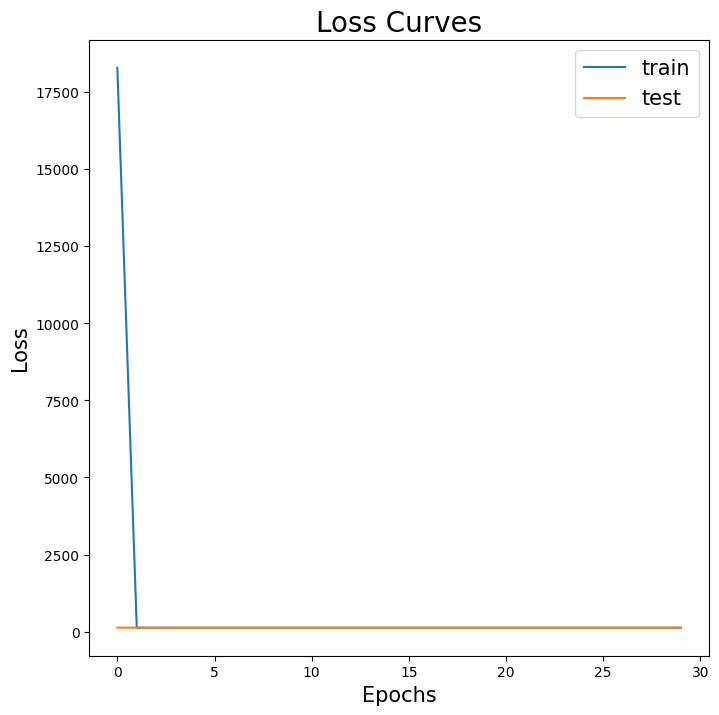

In [23]:
# loss curves
summarize_diagnostics(history)

In [24]:
decoded_imgs = autoencoder.predict(test_ds)

27/27 [==============================] - 3s 64ms/step


In [25]:
# unpack noisy_images and clean_images from tensors pair
noisy_images = []
clean_images = []

for noisy_image, clean_image in test_ds:
   noisy_images.extend(noisy_image.numpy())
   clean_images.extend(clean_image.numpy())

noisy_images_np = np.array(noisy_images)
clean_images_np = np.array(clean_images)

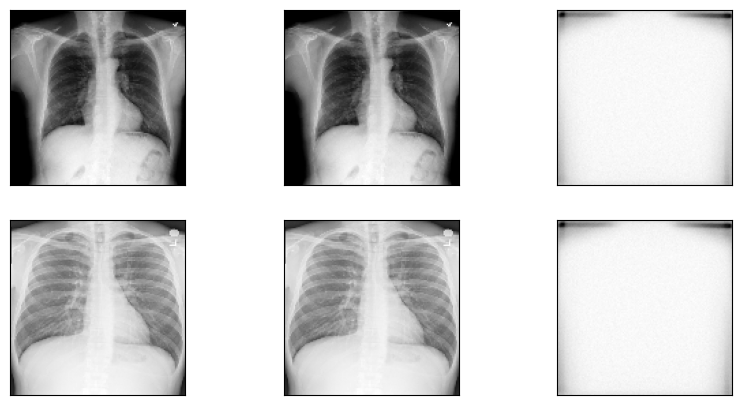

In [26]:
n = 2  # Number of images to display
plt.figure(figsize=(10, 5))
for i in range(n):

    # Display clean_images_np
    ax = plt.subplot(2, 3,  1+(i*3) )
    plt.imshow(clean_images_np[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy_images_np
    ax = plt.subplot(2, 3, 2+(i*3) )
    plt.imshow(noisy_images_np[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy_images_np
    ax = plt.subplot(2, 3, 3+(i*3))
    plt.imshow(decoded_imgs[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# Convolutional Denoising with L2 norm

In [27]:
input = layers.Input(shape=(128, 128, 1))

# Encoder
x = layers.Conv2D(16, (5, 5), activation='relu', padding='same')(input) # (None, 128, 128, 16)
x = layers.MaxPooling2D((2, 2), padding='same')(x)                      # (None, 64, 64, 16)
x = layers.Conv2D(8, (5, 5), activation='relu', padding='same')(x)      # (None, 64, 64, 8)
x = layers.MaxPooling2D((2, 2), padding='same')(x)                      # (None, 32, 32, 8)
x = layers.Conv2D(8, (5, 5), activation='relu', padding='same')(x)      # (None, 32, 32, 8)
x = layers.MaxPooling2D((2, 2), padding='same')(x)                      # (None, 16, 16, 8)
x = layers.Conv2D(8, (5, 5), activation='relu', padding='same')(x)      # (None, 16, 16, 8)
x = layers.MaxPooling2D((2, 2), padding='same')(x)                      # (None, 8, 8, 8)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)      # (None, 8, 8, 8)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)                # (None, 4, 4, 8)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional
# Decoder
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(encoded)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(8, (3, 3), strides=2, activation="relu", padding="same")(x)
decoded = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)


autoencoder = Model(input, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()



Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      416       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 8)         3208      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 8)         1608

In [28]:
# Early stopping
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=0,
                   patience=10,
                   restore_best_weights=True)

# Train
history = autoencoder.fit(train_ds,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          callbacks=[es],
                          validation_data=(val_ds))

Epoch 1/50
124/124 [==============================] - 100s 735ms/step - loss: 19942.9199 - val_loss: 20128.6602
Epoch 2/50
124/124 [==============================] - 14s 105ms/step - loss: 19938.6641 - val_loss: 20128.6641
Epoch 3/50
124/124 [==============================] - 14s 106ms/step - loss: 19938.6582 - val_loss: 20128.6602
Epoch 4/50
124/124 [==============================] - 14s 106ms/step - loss: 19938.6621 - val_loss: 20128.6641
Epoch 5/50
124/124 [==============================] - 14s 106ms/step - loss: 19938.6641 - val_loss: 20128.6641
Epoch 6/50
124/124 [==============================] - 14s 105ms/step - loss: 19938.6602 - val_loss: 20128.6641
Epoch 7/50
124/124 [==============================] - 14s 103ms/step - loss: 19938.6621 - val_loss: 20128.6602
Epoch 8/50
124/124 [==============================] - 14s 103ms/step - loss: 19938.6621 - val_loss: 20128.6582
Epoch 9/50
124/124 [==============================] - 14s 103ms/step - loss: 19938.6602 - val_loss: 20128.6641


In [29]:
# plot learning curves
def summarize_diagnostics(history):
    fig, ax = plt.subplots(1, figsize=(8, 8))
    # plot loss
    ax.set_title('Loss Curves', fontsize=20)
    ax.plot(history.history['loss'], label='train')
    ax.plot(history.history['val_loss'], label='test')
    ax.set_xlabel('Epochs', fontsize=15)
    ax.set_ylabel('Loss', fontsize=15)
    ax.legend(fontsize=15)

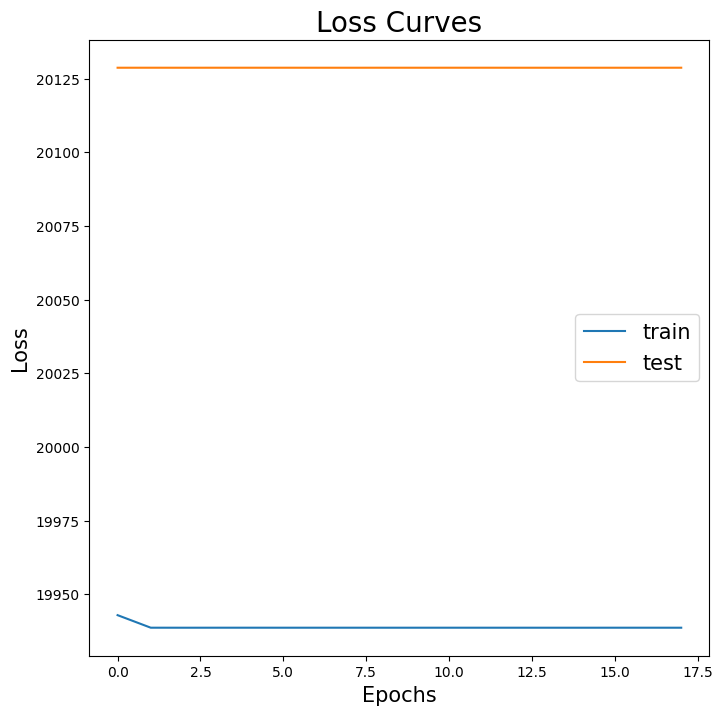

In [30]:
# loss curves
summarize_diagnostics(history)

In [31]:
# Encode and decode some images
# Note that we take them from the test set
decoded_imgs = autoencoder.predict(test_ds)

27/27 [==============================] - 3s 70ms/step


In [32]:
noisy_images = []
clean_images = []

for noisy_image, clean_image in test_ds:
   noisy_images.extend(noisy_image.numpy())
   clean_images.extend(clean_image.numpy())
noisy_images_np = np.array(noisy_images)
clean_images_np = np.array(clean_images)

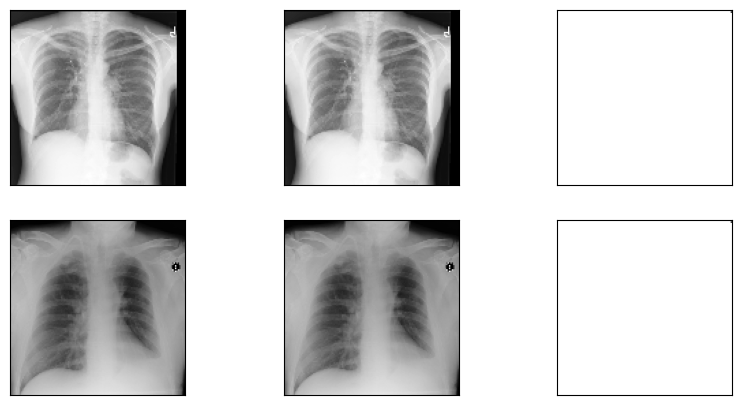

In [33]:
n = 2  # Number of images to display
plt.figure(figsize=(10, 5))
for i in range(n):

    # Display clean_images_np
    ax = plt.subplot(2, 3,  1+(i*3) )
    plt.imshow(clean_images_np[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy_images_np
    ax = plt.subplot(2, 3, 2+(i*3) )
    plt.imshow(noisy_images_np[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy_images_np
    ax = plt.subplot(2, 3, 3+(i*3))
    plt.imshow(decoded_imgs[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# Convolutional Denoising with Huber loss

In [34]:
input = layers.Input(shape=(128, 128, 1))

# Encoder
x = layers.Conv2D(16, (5, 5), activation='relu', padding='same')(input) # (None, 128, 128, 16)
x = layers.MaxPooling2D((2, 2), padding='same')(x)                      # (None, 64, 64, 16)
x = layers.Conv2D(8, (5, 5), activation='relu', padding='same')(x)      # (None, 64, 64, 8)
x = layers.MaxPooling2D((2, 2), padding='same')(x)                      # (None, 32, 32, 8)
x = layers.Conv2D(8, (5, 5), activation='relu', padding='same')(x)      # (None, 32, 32, 8)
x = layers.MaxPooling2D((2, 2), padding='same')(x)                      # (None, 16, 16, 8)
x = layers.Conv2D(8, (5, 5), activation='relu', padding='same')(x)      # (None, 16, 16, 8)
x = layers.MaxPooling2D((2, 2), padding='same')(x)                      # (None, 8, 8, 8)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)      # (None, 8, 8, 8)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)                # (None, 4, 4, 8)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional
# Decoder
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(encoded) # (8, 8, 128)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)        # (16, 16, 64)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)        # (32, 32, 32)
x = layers.Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(x)        # (64, 64, 16)
x = layers.Conv2DTranspose(1, (3, 3), strides=2, activation="relu", padding="same")(x)         # (128, 128, 8)
decoded = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)
# Autoencoder
autoencoder_Huber = Model(input, x)
autoencoder_Huber.compile(optimizer="adam", loss="huber_loss")
autoencoder_Huber.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 16)      416       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 64, 64, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 8)         3208      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 32, 32, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 8)         1608

In [35]:
# Early stopping
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=0,
                   patience=10,
                   restore_best_weights=True)

# Train
history_Huber = autoencoder_Huber.fit(train_ds,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          callbacks=[es],
                          validation_data=(val_ds))

Epoch 1/50
124/124 [==============================] - 16s 96ms/step - loss: 46.3870 - val_loss: 22.6892
Epoch 2/50
124/124 [==============================] - 14s 103ms/step - loss: 20.0485 - val_loss: 18.8712
Epoch 3/50
124/124 [==============================] - 14s 106ms/step - loss: 17.5209 - val_loss: 16.2707
Epoch 4/50
124/124 [==============================] - 14s 105ms/step - loss: 16.1518 - val_loss: 15.5818
Epoch 5/50
124/124 [==============================] - 14s 106ms/step - loss: 15.6755 - val_loss: 15.1214
Epoch 6/50
124/124 [==============================] - 14s 106ms/step - loss: 15.2308 - val_loss: 14.6164
Epoch 7/50
124/124 [==============================] - 14s 104ms/step - loss: 14.8360 - val_loss: 14.1075
Epoch 8/50
124/124 [==============================] - 13s 103ms/step - loss: 14.4110 - val_loss: 14.3622
Epoch 9/50
124/124 [==============================] - 14s 104ms/step - loss: 14.0396 - val_loss: 13.8497
Epoch 10/50
124/124 [==============================] - 1

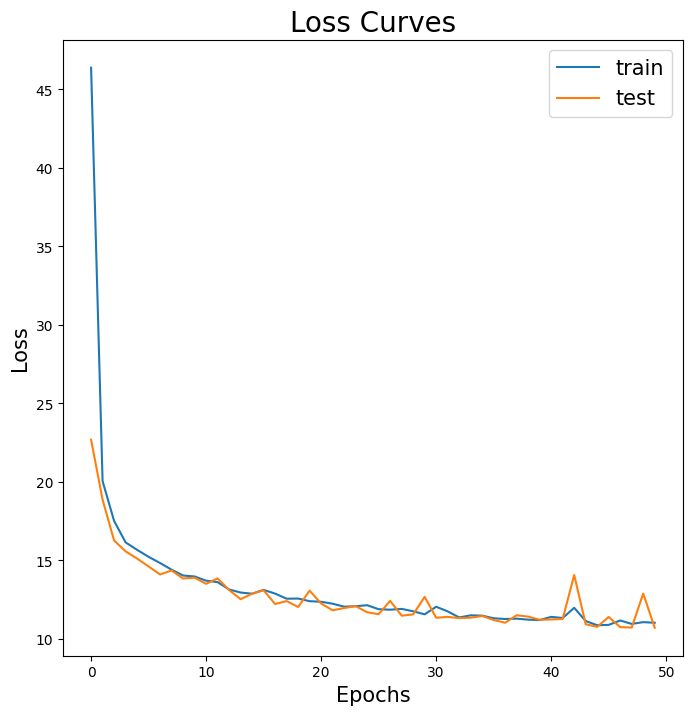

In [36]:
# loss curves
summarize_diagnostics(history_Huber)

In [37]:
decoded_imgs_Huber = autoencoder_Huber.predict(test_ds)

27/27 [==============================] - 2s 59ms/step


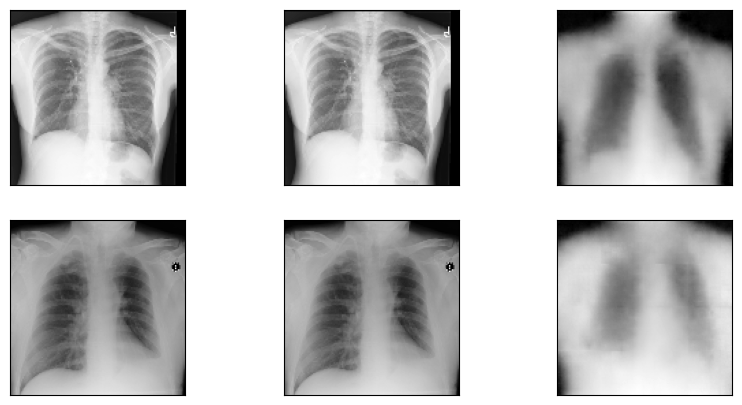

In [38]:
n = 2  # Number of images to display
plt.figure(figsize=(10, 5))
for i in range(n):

    # Display clean_images_np
    ax = plt.subplot(2, 3,  1+(i*3) )
    plt.imshow(clean_images_np[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy_images_np
    ax = plt.subplot(2, 3, 2+(i*3) )
    plt.imshow(noisy_images_np[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy_images_np
    ax = plt.subplot(2, 3, 3+(i*3))
    plt.imshow(decoded_imgs_Huber[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# GAN

In [40]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from keras.datasets.cifar10 import load_data
import matplotlib.pyplot as plt
import time
from IPython import display

from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

from matplotlib import pyplot as plt

In [41]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-ucg04nyc
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-ucg04nyc
  Resolved https://github.com/tensorflow/docs to commit 60abeb06e500fa5edbbac374fc0d8142c8322aef
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2023.10.27.81990-py3-none-any.whl size=184142 sha256=47787c9410654102b2f78245d28ee6be509a1074affb26fb81a29c6f7635a098
  Stored in directory: /tmp/pip-ephem-wheel-cache-2hm5k7bj/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


170498071/170498071 [==============================] - 15s 0us/step


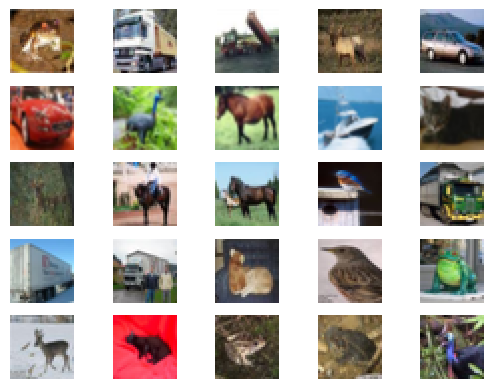

In [42]:
(trainX, trainy), (testX, testy) = load_data()

# plot 25 images
for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(trainX[i])
plt.show()

In [5]:
#############################################################################
#Define generator, discriminator, gan and other helper functions
#Using Sequential method from Keras as it makes the definition of models easy.
#We will use functional way of defining the model for the conditional gan
#but sequential for descriminator and generator as they are straightforward.
#########################################################################

# define the standalone discriminator model
#Given an input image, the Discriminator outputs the likelihood of the image being real.
#Binary classification - true or false (1 or 0). So using sigmoid activation.
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()

	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape)) #16x16x128
	model.add(LeakyReLU(alpha=0.2))

	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) #8x8x128
	model.add(LeakyReLU(alpha=0.2))

	model.add(Flatten()) #shape of 8192
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid')) #shape of 1
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

test_discr = define_discriminator()
print(test_discr.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1)                 8

In [6]:
# define the standalone generator model
# #Given input of latent vector, the Generator produces an image.(here: 32x32)
#latent_dim, for example, can be 100, 1D array of size 100

#Here we are only using Dense and conv2dlayers. But network can be complicated based
#on the application. For example, you can use VGG for super res. GAN.

def define_generator(latent_dim):    #latent_dim is the dimension of the latent vector (e.g., 100)
	model = Sequential()
	# We will reshape input latent vector into 8x8 image as a starting point.
    #So n_nodes for the Dense layer can be 128x8x8 so when we reshape the output
    #it would be 8x8x128 and that can be slowly upscaled to 32x32 image for output.
	n_nodes = 128 * 8 * 8  #8192 nodes
	model.add(Dense(n_nodes, input_dim=latent_dim)) #Dense layer so we can work with 1D latent vector
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((8, 8, 128)))  #8x8x128 dataset from the latent vector.
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #16x16x128
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #32x32x128
	model.add(LeakyReLU(alpha=0.2))
	# generate
	model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) #32x32x3
	return model  #Model not compiled as it is not directly trained like the discriminator.
                    #Generator is trained via GAN combined model.

test_gen = define_generator(100)
print(test_gen.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              827392    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       262272    
 anspose)                                                        
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 128)       262272    
 Transpose)                                           

In [7]:
# define the combined generator and discriminator model, for updating the generator
#Discriminator is trained separately so here only generator will be trained by keeping
#the discriminator constant.
def define_gan(generator, discriminator):
	discriminator.trainable = False  #Discriminator is trained separately. So set to not trainable.
	# connect generator and discriminator
	model = Sequential()
	model.add(generator)
	model.add(discriminator)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [9]:

# load cifar training images
def load_real_samples():
	(trainX, _), (_, _) = load_data()
	# cConvert to float and scale.
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5  #Generator uses tanh activation so rescale
                            #original images to -1 to 1 to match the output of generator.
	return X

# pick a batch of random real samples to train the GAN
#In fact, we will train the GAN on a half batch of real images and another
#half batch of fake images.
#For each real image we assign a label 1 and for fake we assign label 0.
def generate_real_samples(dataset, n_samples):
	# choose random images
	ix = randint(0, dataset.shape[0], n_samples)
	# select the random images and assign it to X
	X = dataset[ix]
	# generate class labels and assign to y
	y = ones((n_samples, 1)) ##Label=1 indicating they are real
	return X, y

# generate n_samples number of latent vectors as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
#Supply the generator, latent_dim and number of samples as input.
#Use the above latent point generator to generate latent points.
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict using generator to generate fake samples.
	X = generator.predict(x_input)
	# Class labels will be 0 as these samples are fake.
	y = zeros((n_samples, 1))  #Label=0 indicating they are fake
	return X, y

# train the generator and discriminator
#We loop through a number of epochs to train our Discriminator by first selecting
#a random batch of images from our true/real dataset.
#Then, generating a set of images using the generator.
#Feed both set of images into the Discriminator.
#Finally, set the loss parameters for both the real and fake images, as well as the combined loss.


In [26]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)  #the discriminator model is updated for a half batch of real samples
                            #and a half batch of fake samples, combined a single batch.
	# manually enumerate epochs and bacthes.
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):

            # Train the discriminator on real and fake images, separately (half batch each)
        #Research showed that separate training is more effective.
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
            ##train_on_batch allows you to update weights based on a collection
            #of samples you provide
            #Let us just capture loss and ignore accuracy value (2nd output below)
			d_loss_real, _ = d_model.train_on_batch(X_real, y_real)

            # generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)

            #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #Average loss if you want to report single..

			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)

            # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        #This is where the generator is trying to trick discriminator into believing
        #the generated image is true (hence value of 1 for y)
			y_gan = ones((n_batch, 1))

            # Generator is part of combined model where it got directly linked with the discriminator
        # Train the generator with latent_dim as x and 1 as y.
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of folling the discriminator then the output would be 1 (true)
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)

            # Print losses on this batch
			print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
	# save the generator model
	g_model.save('/content/drive/MyDrive/gan.h5')

In [34]:
#Train the GAN

latent_dim = 100             # size of the latent space
discriminator = define_discriminator()  # create the discriminator
generator = define_generator(latent_dim) # create the generator
gan_model = define_gan(generator, discriminator) # create the gan
# load image data
dataset = load_real_samples()

# train model
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=20)


Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 12ms/step
Epoch>14, Batch 231/390, d1=0.671, d2=0.709 g=0.911
2/2 [==============================] - 0s 5ms/step
Epoch>14, Batch 232/390, d1=0.768, d2=0.689 g=0.849
2/2 [==============================] - 0s 5ms/step
Epoch>14, Batch 233/390, d1=0.682, d2=0.711 g=0.873
2/2 [==============================] - 0s 6ms/step
Epoch>14, Batch 234/390, d1=0.677, d2=0.686 g=0.931
2/2 [==============================] - 0s 10ms/step
Epoch>14, Batch 235/390, d1=0.700, d2=0.737 g=0.938
2/2 [==============================] - 0s 5ms/step
Epoch>14, Batch 236/390, d1=0.758, d2=0.675 g=0.890
2/2 [==============================] - 0s 12ms/step
Epoch>14, Batch 237/390, d1=0.705, d2=0.662 g=0.900
2/2 [==============================] - 0s 4ms/step
Epoch>14, Batch 238/390, d1=0.733, d2=0.681 g=0.876
2/2 [==============================] - 0s 5ms/step
Epoch>14, Batch 239/390, d1=0.681, d2=0.782 g=0.857
2/2 [==============

Epoch>20, Batch 390/390, d1=0.676, d2=0.744 g=0.740


In [37]:
# Now, let us load the generator model and generate images
from keras.models import load_model
from numpy.random import randn

# Plot generated images
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()


1/1 [==============================] - 0s 81ms/step


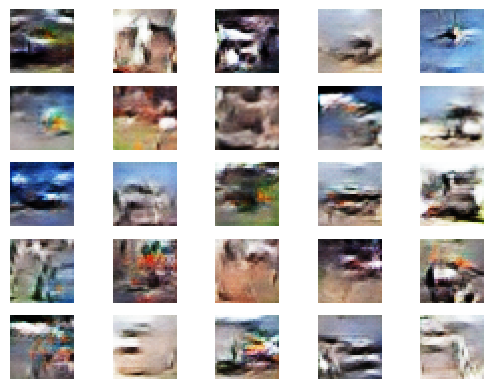

In [38]:
# load model
model = load_model('/content/drive/MyDrive/gan.h5') # Model trained for 100 epochs

# generate images
latent_points = generate_latent_points(100, 25)  #Latent dim and n_samples

# generate images
X = model.predict(latent_points)

# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)

# plot the result
show_plot(X, 5)


In [39]:


def calculate_fid_resnet50v2(real_images, generated_images):
    # Load ResNet50V2 model pre-trained on ImageNet
    resnet_model = ResNet50V2(include_top=False, pooling='avg', input_shape=(32, 32, 3))

    # Preprocess and normalize images
    real_images = preprocess_input(real_images)
    generated_images = preprocess_input(generated_images)

    # Get feature representations from ResNet50V2 model
    real_features = resnet_model.predict(real_images)
    generated_features = resnet_model.predict(generated_images)

    # Calculate mean and covariance for real and generated features
    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_generated, sigma_generated = np.mean(generated_features, axis=0), np.cov(generated_features, rowvar=False)

    # Calculate FID score
    ssd = np.sum((mu_real - mu_generated)**2)
    covsqrt = sqrtm(sigma_real @ sigma_generated)
    if np.iscomplexobj(covsqrt):
        covsqrt = covsqrt.real

    fid = ssd + np.trace(sigma_real + sigma_generated - 2 * covsqrt)

    return fid

In [40]:
# Calculate FID using ResNet50V2
fid_score = calculate_fid_resnet50v2(trainX, X)
print(f"FID Score (ResNet50V2): {fid_score}")



1/1 [==============================] - 0s 33ms/step
FID Score (ResNet50V2): 141.5312991142273


# Conditional GAN

In [43]:
(trainX, trainy), (testX, testy) = load_data()

In [44]:

def define_discriminator(in_shape=(32,32,3), n_classes=10):

    # label input
	in_label = Input(shape=(1,))  #Shape 1
	# embedding for categorical input
    #each label (total 10 classes for cifar), will be represented by a vector of size 50.
    #This vector of size 50 will be learnt by the discriminator
	li = Embedding(n_classes, 50)(in_label) #Shape 1,50
	# scale up to image dimensions with linear activation
	n_nodes = in_shape[0] * in_shape[1]  #32x32 = 1024.
	li = Dense(n_nodes)(li)  #Shape = 1, 1024
	# reshape to additional channel
	li = Reshape((in_shape[0], in_shape[1], 1))(li)  #32x32x1


	# image input
	in_image = Input(shape=in_shape) #32x32x3
	# concat label as a channel
	merge = Concatenate()([in_image, li]) #32x32x4 (4 channels, 3 for image and the other for labels)

	# downsample: This part is same as unconditional GAN upto the output layer.
    #We will combine input label with input image and supply as inputs to the model.
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge) #16x16x128
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe) #8x8x128
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)  #8192  (8*8*128=8192)
	# dropout
	fe = Dropout(0.4)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)  #Shape=1

	# define model
    ##Combine input label with input image and supply as inputs to the model.
	model = Model([in_image, in_label], out_layer)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [44]:
test_discr = define_discriminator()
print(test_discr.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 50)                500       ['input_4[0][0]']             
                                                                                                  
 dense_16 (Dense)            (None, 1, 1024)              52224     ['embedding[0][0]']           
                                                                                                  
 input_5 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                              

In [45]:
test_discr = define_discriminator()
print(test_discr.summary())


# define the standalone generator model
#latent vector and label as inputs

def define_generator(latent_dim, n_classes=10):

	# label input
	in_label = Input(shape=(1,))  #Input of dimension 1
	# embedding for categorical input
    #each label (total 10 classes for cifar), will be represented by a vector of size 50.
	li = Embedding(n_classes, 50)(in_label) #Shape 1,50

	# linear multiplication
	n_nodes = 8 * 8  # To match the dimensions for concatenation later in this step.
	li = Dense(n_nodes)(li) #1,64
	# reshape to additional channel
	li = Reshape((8, 8, 1))(li)


	# image generator input
	in_lat = Input(shape=(latent_dim,))  #Input of dimension 100

	# foundation for 8x8 image
    # We will reshape input latent vector into 8x8 image as a starting point.
    #So n_nodes for the Dense layer can be 128x8x8 so when we reshape the output
    #it would be 8x8x128 and that can be slowly upscaled to 32x32 image for output.
    #Note that this part is same as unconditional GAN until the output layer.
    #While defining model inputs we will combine input label and the latent input.
	n_nodes = 128 * 8 * 8
	gen = Dense(n_nodes)(in_lat)  #shape=8192
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((8, 8, 128))(gen) #Shape=8x8x128
	# merge image gen and label input
	merge = Concatenate()([gen, li])  #Shape=8x8x129 (Extra channel corresponds to the label)
	# upsample to 16x16
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge) #16x16x128
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 32x32
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen) #32x32x128
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(3, (8,8), activation='tanh', padding='same')(gen) #32x32x3
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model   #Model not compiled as it is not directly trained like the discriminator.

test_gen = define_generator(100, n_classes=10)
print(test_gen.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 50)                500       ['input_6[0][0]']             
                                                                                                  
 dense_18 (Dense)            (None, 1, 1024)              52224     ['embedding_1[0][0]']         
                                                                                                  
 input_7 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                            

In [45]:
# #Generator is trained via GAN combined model.
# define the combined generator and discriminator model, for updating the generator
#Discriminator is trained separately so here only generator will be trained by keeping
#the discriminator constant.
def define_gan(g_model, d_model):
	d_model.trainable = False  #Discriminator is trained separately. So set to not trainable.

    ## connect generator and discriminator...
	# first, get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input  #Latent vector size and label size
	# get image output from the generator model
	gen_output = g_model.output  #32x32x3

	# generator image output and corresponding input label are inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [46]:
# load cifar images
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()   #cifar
	# convert to floats and scale
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5   #Generator uses tanh activation so rescale
                            #original images to -1 to 1 to match the output of generator.
	return [X, trainy]

In [47]:
# # select real samples
# pick a batch of random real samples to train the GAN
#In fact, we will train the GAN on a half batch of real images and another
#half batch of fake images.
#For each real image we assign a label 1 and for fake we assign label 0.
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels and assign to y (don't confuse this with the above labels that correspond to cifar labels)
	y = ones((n_samples, 1))  #Label=1 indicating they are real
	return [X, labels], y

In [48]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

In [49]:

# use the generator to generate n fake examples, with class labels
#Supply the generator, latent_dim and number of samples as input.
#Use the above latent point generator to generate latent points.
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))  #Label=0 indicating they are fake
	return [images, labels_input], y

In [50]:

# train the generator and discriminator
#We loop through a number of epochs to train our Discriminator by first selecting
#a random batch of images from our true/real dataset.
#Then, generating a set of images using the generator.
#Feed both set of images into the Discriminator.
#Finally, set the loss parameters for both the real and fake images, as well as the combined loss.
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)  #the discriminator model is updated for a half batch of real samples
                            #and a half batch of fake samples, combined a single batch.
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):

             # Train the discriminator on real and fake images, separately (half batch each)
        #Research showed that separate training is more effective.
			# get randomly selected 'real' samples
            # get randomly selected 'real' samples
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)

            # update discriminator model weights
            ##train_on_batch allows you to update weights based on a collection
            #of samples you provide
			d_loss_real, _ = d_model.train_on_batch([X_real, labels_real], y_real)

			# generate 'fake' examples
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss_fake, _ = d_model.train_on_batch([X_fake, labels], y_fake)

            #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #Average loss if you want to report single..

			# prepare points in latent space as input for the generator
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)

            # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        #This is where the generator is trying to trick discriminator into believing
        #the generated image is true (hence value of 1 for y)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
             # Generator is part of combined model where it got directly linked with the discriminator
        # Train the generator with latent_dim as x and 1 as y.
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of folling the discriminator then the output would be 1 (true)
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			# Print losses on this batch
			print('Epoch>%d, Batch%d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
	# save the generator model
	g_model.save('/content/drive/MyDrive/cifar_conditional_generator_25epochs.h5')

In [53]:
# train the generator and discriminator
#We loop through a number of epochs to train our Discriminator by first selecting
#a random batch of images from our true/real dataset.
#Then, generating a set of images using the generator.
#Feed both set of images into the Discriminator.
#Finally, set the loss parameters for both the real and fake images, as well as the combined loss.
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)  #the discriminator model is updated for a half batch of real samples
                            #and a half batch of fake samples, combined a single batch.
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):

             # Train the discriminator on real and fake images, separately (half batch each)
        #Research showed that separate training is more effective.
			# get randomly selected 'real' samples
            # get randomly selected 'real' samples
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)

            # update discriminator model weights
            ##train_on_batch allows you to update weights based on a collection
            #of samples you provide
			d_loss_real, _ = d_model.train_on_batch([X_real, labels_real], y_real)

			# generate 'fake' examples
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss_fake, _ = d_model.train_on_batch([X_fake, labels], y_fake)

            #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #Average loss if you want to report single..

			# prepare points in latent space as input for the generator
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)

            # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        #This is where the generator is trying to trick discriminator into believing
        #the generated image is true (hence value of 1 for y)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
             # Generator is part of combined model where it got directly linked with the discriminator
        # Train the generator with latent_dim as x and 1 as y.
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of folling the discriminator then the output would be 1 (true)
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			# Print losses on this batch
			print('Epoch>%d, Batch%d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
	# save the generator model
	g_model.save('/content/drive/MyDrive/cifar_conditional_generator_25epochs.h5')


In [55]:
#Train the GAN

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=30)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 6ms/step
Epoch>24, Batch231/390, d1=0.667, d2=0.648 g=0.887
2/2 [==============================] - 0s 6ms/step
Epoch>24, Batch232/390, d1=0.684, d2=0.633 g=0.852
2/2 [==============================] - 0s 5ms/step
Epoch>24, Batch233/390, d1=0.704, d2=0.680 g=0.849
2/2 [==============================] - 0s 14ms/step
Epoch>24, Batch234/390, d1=0.740, d2=0.743 g=0.805
2/2 [==============================] - 0s 21ms/step
Epoch>24, Batch235/390, d1=0.689, d2=0.668 g=0.837
2/2 [==============================] - 0s 17ms/step
Epoch>24, Batch236/390, d1=0.699, d2=0.738 g=0.769
2/2 [==============================] - 0s 6ms/step
Epoch>24, Batch237/390, d1=0.728, d2=0.763 g=0.750
2/2 [==============================] - 0s 8ms/step
Epoch>24, Batch238/390, d1=0.715, d2=0.728 g=0.771
2/2 [==============================] - 0s 11ms/step
Epoch>24, Batch239/390, d1=0.700, d2=0.679 g=0.821
2/2 [======================

Epoch>30, Batch390/390, d1=0.722, d2=0.669 g=0.839


4/4 [==============================] - 1s 28ms/step


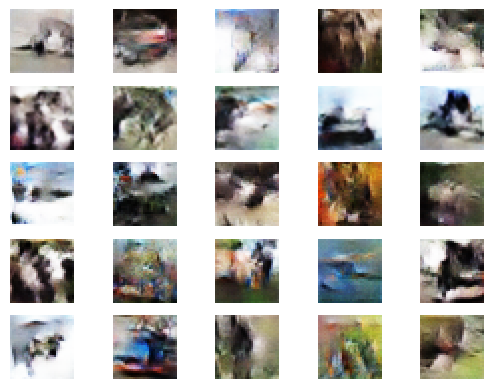

In [51]:
##########################################################
# Now, let us load the generator model and generate images
# Lod the trained model and generate a few images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
import numpy as np
#

#Note: CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse,
# ship, truck

# load model
model = load_model('/content/drive/MyDrive/cifar_conditional_generator_25epochs.h5')

# generate multiple images

latent_points, labels = generate_latent_points(100, 100)
# specify labels - generate 10 sets of labels each gping from 0 to 9
labels = asarray([x for _ in range(10) for x in range(10)])
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)
# plot the result (10 sets of images, all images in a column should be of same class in the plot)
# Plot generated images
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()

show_plot(X, 5)

In [52]:


def calculate_fid_resnet50v2(real_images, generated_images):
    # Load ResNet50V2 model pre-trained on ImageNet
    resnet_model = ResNet50V2(include_top=False, pooling='avg', input_shape=(32, 32, 3))

    # Preprocess and normalize images
    real_images = preprocess_input(real_images)
    generated_images = preprocess_input(generated_images)

    # Get feature representations from ResNet50V2 model
    real_features = resnet_model.predict(real_images)
    generated_features = resnet_model.predict(generated_images)

    # Calculate mean and covariance for real and generated features
    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_generated, sigma_generated = np.mean(generated_features, axis=0), np.cov(generated_features, rowvar=False)

    # Calculate FID score
    ssd = np.sum((mu_real - mu_generated)**2)
    covsqrt = sqrtm(sigma_real @ sigma_generated)
    if np.iscomplexobj(covsqrt):
        covsqrt = covsqrt.real

    fid = ssd + np.trace(sigma_real + sigma_generated - 2 * covsqrt)

    return fid

In [53]:
# Calculate FID using ResNet50V2
fid_score = calculate_fid_resnet50v2(trainX, X)
print(f"FID Score (ResNet50V2): {fid_score}")

4/4 [==============================] - 1s 160ms/step
FID Score (ResNet50V2): 7.785482278318212e+26
